In [13]:
%matplotlib inline
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
R = 0.22 * u.pc
dr = 0.20 * u.pc
pixel_width = 7.5 * u.arcsec
distance = 414 * u.pc
pix_pc = pixel_width.to(u.radian).value * distance

v0 = 13.6 * u.km/u.s
vexp = 2.2 * u.km/u.s
vstep = 0.099 * u.km/u.s

## Sample Particles on Shell

### Sample Cube then Reject Particles Off Shell

In [15]:
#%%timeit
oversample_factor = 1e5
n_points = int(((2*R+dr) / pix_pc) * oversample_factor)

x = np.random.uniform(-R - dr/2, R + dr/2, n_points)
y = np.random.uniform(-R - dr/2, R + dr/2, n_points)
z = np.random.uniform(-R - dr/2, R + dr/2, n_points)

r = np.sqrt(x**2. + y**2. + z**2.)
on_shell = (r >= R.value - dr.value/2) & (r < R.value + dr.value/2)

x = x[on_shell]
y = y[on_shell]
z = z[on_shell]
r = r[on_shell]

print("Accept {}% of particles.".format(round(x.size / n_points, 3)*100))
vz = vexp * z / r + v0

Accept 49.6% of particles.


### Sample Spherical Shell in Uniform Volumes
This method is faster to generate the same number of particles on
a shell.

In [16]:
#%%timeit
oversample_factor = 3**3.
shell_volume = (4./3.) * np.pi * ((R+dr/2)**3. - (R-dr/2)**3.)
n_points = (shell_volume / pix_pc ** 3.) * oversample_factor

#Sample Unit Sphere
theta = np.random.uniform(0, 2*np.pi, n_points)
z0 = np.random.uniform(-1, 1, n_points)
x0 = np.sqrt(1 - z0**2.)*np.cos(theta)
y0 = np.sqrt(1 - z0**2.)*np.sin(theta)

#Sample radius from distribution that has uniform volume density
r = np.random.uniform((R - dr/2)**3., (R + dr/2)**3., n_points) ** (1./3.)
x, y, z = x0*r, y0*r, z0*r
vz = vexp * z / r + v0


## Plot Particle Velocity

In [17]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# #ax = fig.add_subplot(111)
# ax.scatter(x, y, z, c=vz)
# fig.tight_layout()

## Bin into voxels with width [dx, dy, dvz]

In [37]:
#%%timeit
pad = 5
#Midpoint of middle pixel should be at x,y = 0 (center of shell).
pix_start = -R - dr/2 - pad*pix_pc
pix_end = R + dr/2 + pad*pix_pc
pix_bins = symmetric_bins(pix_start.value, pix_end.value, pix_pc.value)


channel_pad = 5
#Midpoint of middle channel should be v0
vstart = v0 - vexp - channel_pad*vstep
vend = v0 + vexp + channel_pad*vstep
vz_bins = symmetric_bins(vstart.value, vend.value, vstep.value)

### Show Sum Along Z-Axis

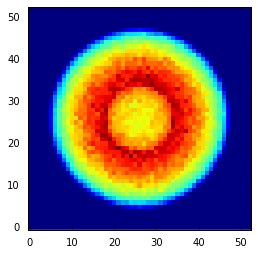

In [38]:
#%%timeit
ppv, edges = np.histogramdd((x, y, vz.value), bins=(pix_bins, pix_bins, vz_bins))
plt.imshow(np.sum(ppv, axis=2), interpolation='none')

### Smooth with a Gaussian With FWHM = 2 Pixels

In [39]:
#%%timeit
from astropy.convolution import Gaussian2DKernel, convolve, convolve_fft
gauss = Gaussian2DKernel(stddev = 2 / np.sqrt(8 * np.log(2))) #2 pixels FWHM
for i in range(ppv.shape[2]):
    ppv[:,:,i] = convolve_fft(ppv[:,:,i], gauss, normalize_kernel=True)
ppv = np.swapaxes(ppv, 0, 2)

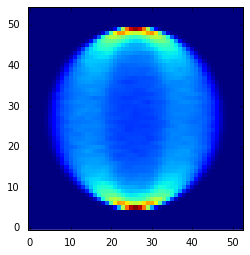

In [40]:
plt.imshow(np.sum(ppv, 2), interpolation='none')
plt.show()
#plt.scatter([0,21,42],[0,21,42])

### Test implementation of particle method in `shell_model.py`

In [41]:
import shell_model
import shells
from spectral_cube import SpectralCube
cubefile12co = "../nro_maps/12CO_20161017_FOREST-BEARS_spheroidal_xyb_grid7.5_0.099kms_YS.fits"
regionfile = "../shell_candidates/AllShells.reg"

# For Shell 18
n=17
shell_list = shells.get_shells()
shell = shell_list[n]

outfile = '../turbulent_model/shell18_particles.fits'
model_pars = {
    'outfile':"'{}'".format(outfile),
    'dist':414*u.pc, # pc
    'pix_size':7.5*u.arcsec, # arcsec
    'vstep':0.099*u.km/u.s, # km/s
    'acen':shell.ra, # deg
    'dcen':shell.dec, # deg
    'thickness':0.0, # pc
    'fwhm':0.0, # km/s
    'beta':0.0, # spectral index
    'R':0.22*u.pc, # pc
    'dr':0.2*u.pc, # pc
    'vexp':2.2*u.km/u.s, # km/s
    'depth_offset':0.0, # pc
    'vel_offset':0.0, # km/s
    'v0':13.6*u.km/u.s, # km/s
    'ignore_cloud':1, #Ignore cloud.
    'method':'sample',
    'write_fits':False,
    'samples_per_voxel':27}

In [56]:
#%%timeit
ppv = shell_model.ppv_model(**model_pars)
s = SpectralCube.read(ppv)
pv_length = abs(s.latitude_extrema[1] - s.latitude_extrema[0])

In [57]:
pv = shells.pv_slice(s, model_pars['acen'], model_pars['dcen'], length=pv_length)

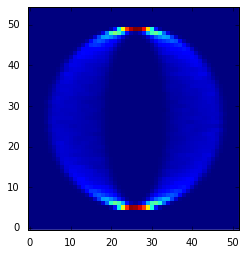

In [59]:
plt.imshow(pv.data, interpolation='none')